### Created by yunsuxiaozi

### Import necessary libraries

In [1]:
#https://www.kaggle.com/code/ttahara/hms-hbac-resnet34d-baseline-training
#https://www.kaggle.com/code/ttahara/hms-hbac-resnet34d-baseline-inference
#necessary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch 
import timm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import random
import warnings
warnings.filterwarnings('ignore')

### pretrain_model

In [2]:
model = timm.create_model(
    'resnet34d', 
    pretrained=True, 
    num_classes=6, 
    in_chans=1
)

### Config

In [3]:
class CFG:
    SEED = 2024
    IMAGE_TRANSFORM = transforms.Resize((512, 512))
    BATCH_SIZE = 32
    NUM_EPOCHS = 10
    LABELS = ['seizure', 'lpd', 'gpd', 'lrda', 'grda', 'other']
    FEATS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']

### Seed 

In [4]:
def seed_everything(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    

seed_everything(CFG.SEED)

### labels

In [5]:
train_df = pd.read_csv("data/train.csv")
train_df = train_df[train_df['eeg_sub_id'] == 0]


for label in CFG.LABELS:
    group=train_df[f'{label}_vote'].groupby(train_df['spectrogram_id']).sum()
    label_vote_sum = pd.DataFrame({'spectrogram_id': group.index, f'{label}_vote_sum': group.values})
    if label=='seizure':
        train_feats=label_vote_sum
    else:
        train_feats=train_feats.merge(label_vote_sum, on='spectrogram_id', how='left')
        
train_feats['total_vote'] = 0

for label in CFG.LABELS:
      train_feats['total_vote']+=train_feats[f'{label}_vote_sum']

for label in CFG.LABELS:
      train_feats[f'{label}_vote']=train_feats[f'{label}_vote_sum']/train_feats['total_vote']

choose_cols=['spectrogram_id']

for label in CFG.LABELS:
    choose_cols += [f'{label}_vote']

train_feats=train_feats[choose_cols]
train_feats['path']=train_feats['spectrogram_id'].apply(lambda x: "data/train_spectrograms/" + str(x) + ".parquet" )
train_feats.head()

,spectrogram_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,path
0,353733,1.000000,0.0000,0.000000,0.000,0.000000,0.000000,data/train_spectrograms/353733.parquet
1,924234,0.000000,0.0000,0.454545,0.000,0.090909,0.454545,data/train_spectrograms/924234.parquet
2,999431,0.000000,0.0625,0.000000,0.875,0.000000,0.062500,data/train_spectrograms/999431.parquet
3,1084844,0.000000,0.0000,0.000000,1.000,0.000000,0.000000,data/train_spectrograms/1084844.parquet
4,1219001,0.692308,0.0000,0.307692,0.000,0.000000,0.000000,data/train_spectrograms/1219001.parquet


### Train_Test_split

In [6]:
split = 0.8
random_num = np.arange(len(train_feats))
np.random.shuffle(random_num)
split_num = int(len(train_feats)*split)
train_idx=random_num[:split_num]
test_idx=random_num[split_num:]

print(f"train_idx")

for label in CFG.LABELS:
    print(f"{label}:{train_feats.iloc[train_idx][label+'_vote'].sum()}")

print(f"test_idx")

for label in CFG.LABELS:
    print(f"{label}:{train_feats.iloc[test_idx][label+'_vote'].sum()}")

train_idx
seizure:1627.5429277590763
lpd:992.4822588679306
gpd:775.8651789477645
lrda:615.1320480036595
grda:1212.1043590244096
other:3686.873227397159
test_idx
seizure:392.5208838740165
lpd:246.74863188352396
gpd:215.62070678472827
lrda:153.22201301507783
grda:290.4126848953289
other:929.4750795473245


### Loss function :Kullback Leibler Divergence

In [7]:
def KL_loss(p,q):
    epsilon=10 ** (-15)
    p = torch.clip(p, epsilon, 1 - epsilon)
    q = nn.functional.log_softmax(q, dim=1)
    return torch.mean(torch.sum(p * (torch.log(p) - q), dim=1))

### get_batch_data

In [8]:
def get_batch(paths, batch_size=CFG.BATCH_SIZE):
    eps=1e-6
    batch_data=[]
    for path in paths:
        data=pd.read_parquet(path[0])
        data = data.fillna(-1).values[:, 1:].T
        data=data[:,0:300] 
        data=np.clip(data,np.exp(-6),np.exp(10))
        data= np.log(data)
        data_mean=data.mean(axis=(0,1))
        data_std=data.std(axis=(0,1))
        data=(data-data_mean)/(data_std+eps)
        data_tensor = torch.unsqueeze(torch.Tensor(data), dim=0)
        data=CFG.IMAGE_TRANSFORM(data_tensor)
        batch_data.append(data)
    batch_data=torch.stack(batch_data)
    return batch_data

### Model training

In [9]:
optimizer=optim.AdamW(
    model.parameters(),
    lr=0.001,
    betas=(0.5,0.999),
    weight_decay=0.01
)

device ='cuda' if  torch.cuda.is_available() else 'cpu'
print(f"device:{device}")
model.to(device)

train_losses=[]
test_losses=[]

print(f"start")

for epoch in range(CFG.NUM_EPOCHS):
    print(f"epoch {epoch}:")
    model.train()
    train_loss=[]
    random_num=np.arange(len(train_idx))
    np.random.shuffle(random_num)
    train_idx=train_idx[random_num]
    
    for idx in range(0, len(train_idx), CFG.BATCH_SIZE): 
        optimizer.zero_grad()
        train_idx1 = train_idx[idx: idx + CFG.BATCH_SIZE]
        train_X1_path = train_feats[['path']].iloc[train_idx1].values
        train_X1 = get_batch(train_X1_path, batch_size=CFG.BATCH_SIZE)
        train_y1 = train_feats[CFG.FEATS].iloc[train_idx1].values
        train_y1 = torch.Tensor(train_y1)
        train_pred = model(train_X1.to(device))
        loss = KL_loss(train_y1.to(device), train_pred.to(device)).to(device)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
        
    train_loss=np.mean(np.array(train_loss))
    print(f"train_loss:{train_loss}")
    test_loss=[]
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(test_idx), CFG.BATCH_SIZE): 
            test_idx1= test_idx[idx:idx + CFG.BATCH_SIZE]
            test_X1_path=train_feats[['path']].iloc[test_idx1].values
            test_X1=get_batch(test_X1_path, batch_size=CFG.BATCH_SIZE)
            test_y1=train_feats[CFG.FEATS].iloc[test_idx1].values
            test_y1=torch.Tensor(test_y1)
            test_pred=model(test_X1.to(device))
            loss=KL_loss(test_y1.to(device),test_pred.to(device)).to(device)
            test_loss.append(loss.detach().cpu().numpy())
    test_loss=np.mean(np.array(test_loss))
    print(f"test_loss:{test_loss}")
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print("-" * 50)

device:cuda
start
epoch 0:
train_loss:0.8849838376045227
test_loss:0.9196282625198364
--------------------------------------------------
epoch 1:
train_loss:0.6940669417381287
test_loss:0.8342322111129761
--------------------------------------------------
epoch 2:
train_loss:0.6192984580993652
test_loss:0.7144370675086975
--------------------------------------------------
epoch 3:
train_loss:0.5579016804695129
test_loss:0.7617588043212891
--------------------------------------------------
epoch 4:
train_loss:0.49599799513816833
test_loss:0.6525914072990417
--------------------------------------------------
epoch 5:
train_loss:0.4383402168750763
test_loss:0.7451339960098267
--------------------------------------------------
epoch 6:
train_loss:0.39113175868988037
test_loss:0.6559407711029053
--------------------------------------------------
epoch 7:
train_loss:0.32329756021499634
test_loss:0.6529508233070374
--------------------------------------------------
epoch 8:
train_loss:0.26708

### Plot train_losses VS test_losses

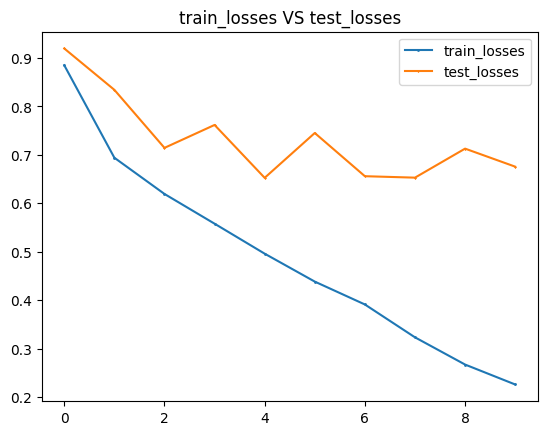

In [10]:
plt.title("train_losses VS test_losses")
epochs=[i for i in range(len(train_losses))]

plt.plot(
    epochs,
    train_losses,
    marker="o",
    markersize=1,
    label="train_losses"
)

plt.plot(
    epochs,
    test_losses,
    marker="x",
    markersize=1,
    label="test_losses"
)

plt.legend()
plt.show()

### Save model

In [11]:
torch.save(model.to('cpu'), "HMS_resnet.pth")